<a href="https://colab.research.google.com/github/mirchandani-mohnish/ClusterMetrics/blob/main/kmeans.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
from sklearn import datasets
import matplotlib.pyplot as plt
import kagglehub
import pandas as pd
import os
import seaborn as sns
import numpy as np
from sklearn.cluster import KMeans
from sklearn.preprocessing import LabelEncoder, OrdinalEncoder
from sklearn.metrics import adjusted_rand_score, mutual_info_score
"""
just functions to help drving the results and displaying it
"""
def print_metrics(X, true_labels_values, predicted_labels, print_res = True):
    true_labels = LabelEncoder().fit_transform(true_labels_values)
    # Adjusted Rand Score
    try:
        print(f"Adjusted Rand score: {adjusted_rand_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Adjusted Rand score failed: {str(e)}")

    # Mutual Information Score
    try:
        print(f"Mutual Information score: {mutual_info_score(true_labels, predicted_labels):.4f}")
    except Exception as e:
        print(f"Mutual Information score failed: {str(e)}")
    print("-------------------------------------------------------------------")

## Iris Feature comparisons
When drawing the Iris dataset histogram for the 4 datatset feature, we can observe the following:<br>
- in **petal length** histogram: each rose type has a almost a normal distribution around a median value. and median values are well seperated from each other means there a few overlapping values of these two features for each rose type.<br>
- in **petal width** histogram: like petal length but with a slightly better seperation of the value as we see the overlapping values region is smaller. 
- in **sepal length** and **sepal width** histograms: it is quite the opposite. for example, in sepal length histogram values of each type overlap making harder for a clustering algorithm to seperate them and consider them a different clustter.<br>
from this observation, the most feature that differentiate the 3 classes is petal width. To make sure of this we run k-means clustering using only one feature at a time to compare between petal length an petal width.Then compare ARI values of both to see which gives better representaion of the data and better seperation. and we got the following results : (ARI with petal_length: 0.87 ARI with petal_width: 0.89) which supports our selection. So we need this feature to comtribute more when calculating the dissimilarities between datapoints.


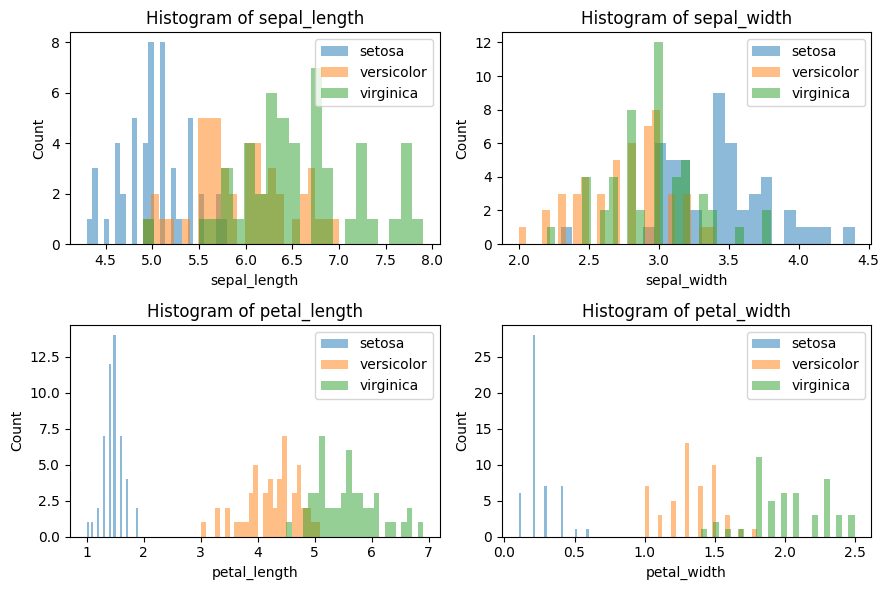

In [7]:
# Step 1: Download the dataset
path = kagglehub.dataset_download("himanshunakrani/iris-dataset")
# Step 2: Load the dataset
iris = pd.read_csv(os.path.join(path, "iris.csv"))
# Step 3: Plot histograms
features = ['sepal_length', 'sepal_width', 'petal_length', 'petal_width']
species = iris['species'].unique()
fig, axes = plt.subplots(2, 2, figsize=(9, 6))
axes = axes.flatten()

for i, feature in enumerate(features):
    for spec in species:
        subset = iris[iris['species'] == spec]
        axes[i].hist(subset[feature], bins=25, alpha=0.5, label=spec)
    axes[i].set_title(f"Histogram of {feature}")
    axes[i].set_xlabel(feature)
    axes[i].set_ylabel("Count")
    axes[i].legend()

plt.tight_layout()
plt.show()


To strength our feature selection let's run k-means clustering using only one feature at a time, then see which gives better class separation.<br>
as maybe it's hard to see it by eye

In [8]:
 # petal_length
kmeans_len = KMeans(n_clusters=3, random_state=0).fit(iris[['petal_length']])
ari_len = adjusted_rand_score(iris['species'], kmeans_len.labels_)

# petal_width
kmeans_wid = KMeans(n_clusters=3, random_state=0).fit(iris[['petal_width']])
ari_wid = adjusted_rand_score(iris['species'], kmeans_wid.labels_)

print(f"ARI with petal_length: {ari_len:.2f}")
print(f"ARI with petal_width: {ari_wid:.2f}")


ARI with petal_length: 0.87
ARI with petal_width: 0.89


## Modified K-mean with weaighted feature

In [9]:
def k_means(X, k, feature_weights=None, max_iter=300, tol=1e-4,seed=0):

    #decide which distance metric to use based on the feature weights
    if feature_weights is not None:
        distance_metric = lambda x, y, w: np.sqrt(np.sum(w * (x - y) ** 2, axis=2))
    else:
        distance_metric = lambda x,y, w: np.linalg.norm(x-y, axis=2) #w here not used
    # Step 1: Initialize centroids randomly from the dataset
    n_samples, n_features = X.shape
    rng = np.random.default_rng(seed)
    centroids = X[rng.choice(n_samples, k, replace=False)]
    for _ in range(max_iter):
        # Step 2: Assign each data point to the nearest centroid
        distances = distance_metric(X[:, np.newaxis],centroids,feature_weights)
        cluster_assignments = np.argmin(distances, axis=1)

        # Step 3: Compute new centroids
        new_centroids = np.array([X[cluster_assignments == j].mean(axis=0) if np.any(cluster_assignments == j) else centroids[j]
                                  for j in range(k)])

        # Step 4: Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return cluster_assignments, centroids


## Metrics comparison

In [23]:
iris = iris.dropna()
iris_filtered = iris.select_dtypes(include=['float64'])

X_iris_one_feature = iris_filtered[['petal_width']].to_numpy() #choosing one feature (petal_width) for clustering
X_iris = iris_filtered.to_numpy()
k_iris = 3
# Cluster the data using normal distance metric, weighted distance metric, single feature.
normal_clustering_label, centroids_normal_clustering = k_means(X_iris, k_iris)
weighted_clustering_label, centroids_weighted_clustering = k_means(X_iris, k_iris, feature_weights=[0.3, 0.3, 1, 2])
one_feature_clustering_label, centroids_one_feature_clustering = k_means(X_iris_one_feature, k_iris)


print("N############### Normal Clustering ################# ")
print_metrics(X_iris, iris['species'], normal_clustering_label)
print("N############ wheighted Clustering ################# ")
print_metrics(X_iris, iris['species'], weighted_clustering_label)
print("N########### single feature Clustering ############# ")
print_metrics(X_iris, iris['species'], one_feature_clustering_label)

N############### Normal Clustering ################# 
Adjusted Rand score: 0.7302
Mutual Information score: 0.8256
-------------------------------------------------------------------
N############ wheighted Clustering ################# 
Adjusted Rand score: 0.8512
Mutual Information score: 0.9261
-------------------------------------------------------------------
N########### single feature Clustering ############# 
Adjusted Rand score: 0.8858
Mutual Information score: 0.9554
-------------------------------------------------------------------


## Visual comparison
in this section we plat the original labels vs normal, weighted feature, single feature clustering

## Modified K-mean with weaighted feature

In [ ]:
def k_means(X, k, feature_weights=None, max_iter=300, tol=1e-4,seed=0):

    #decide which distance metric to use based on the feature weights
    if feature_weights is not None:
        distance_metric = lambda x, y, w: np.sqrt(np.sum(w * (x - y) ** 2, axis=2))
    else:
        distance_metric = lambda x,y, w: np.linalg.norm(x-y, axis=2) #w here not used
    # Step 1: Initialize centroids randomly from the dataset
    n_samples, n_features = X.shape
    rng = np.random.default_rng(seed)
    centroids = X[rng.choice(n_samples, k, replace=False)]
    for _ in range(max_iter):
        # Step 2: Assign each data point to the nearest centroid
        distances = distance_metric(X[:, np.newaxis],centroids,feature_weights)
        cluster_assignments = np.argmin(distances, axis=1)

        # Step 3: Compute new centroids
        new_centroids = np.array([X[cluster_assignments == j].mean(axis=0) if np.any(cluster_assignments == j) else centroids[j]
                                  for j in range(k)])

        # Step 4: Check for convergence
        if np.linalg.norm(new_centroids - centroids) < tol:
            break

        centroids = new_centroids

    return cluster_assignments, centroids


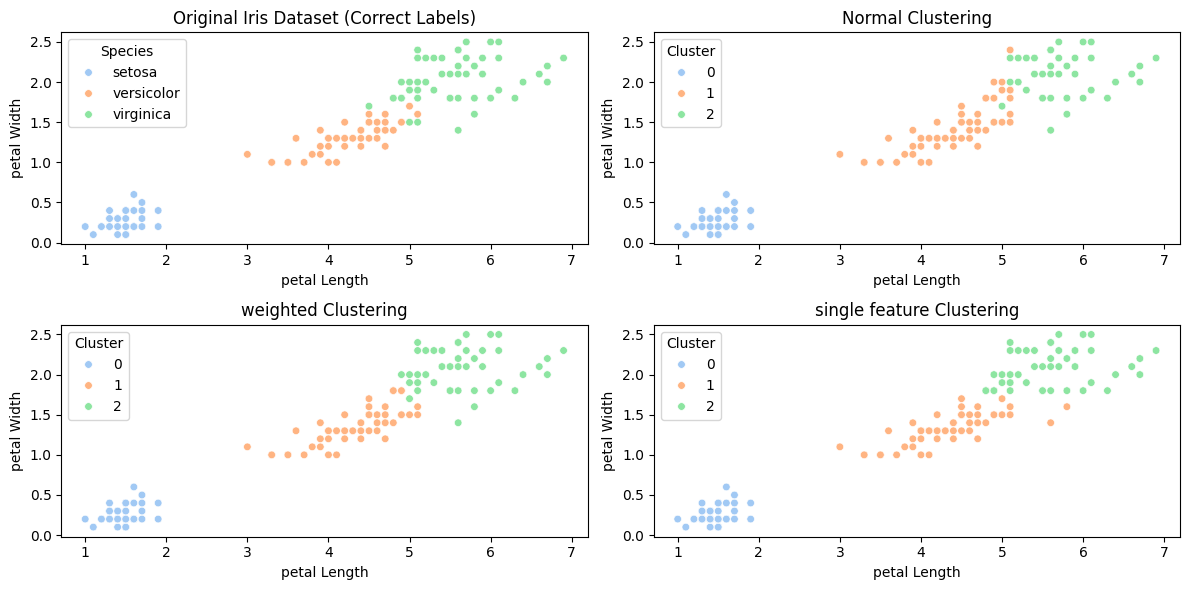

In [ ]:
# Create a figure with three subplots
clusters_colors = "pastel"
fig, axes = plt.subplots(2, 2, figsize=(12, 6))
axes = axes.flatten()
# Plot 1: Original Iris Dataset with Correct Labels
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue="species", palette=clusters_colors, ax=axes[0])
axes[0].set_title("Original Iris Dataset (Correct Labels)")
axes[0].set_xlabel("petal Length")
axes[0].set_ylabel("petal Width")
axes[0].legend(title="Species")

# Plot 2: Custom AHC Labels (labels_base_iris)
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue=normal_clustering_label, palette=clusters_colors, ax=axes[1])
axes[1].set_title("Normal Clustering")
axes[1].set_xlabel("petal Length")
axes[1].set_ylabel("petal Width")
axes[1].legend(title="Cluster")

# Plot 3: wheighted feature clustering
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue=weighted_clustering_label, palette=clusters_colors, ax=axes[2])
axes[2].set_title("weighted Clustering")
axes[2].set_xlabel("petal Length")
axes[2].set_ylabel("petal Width")
axes[2].legend(title="Cluster")

# Plot 3: Sklearn AHC Labels (labels_sklearn_iris)
sns.scatterplot(data=iris, x="petal_length", y="petal_width", hue=one_feature_clustering_label, palette=clusters_colors, ax=axes[3])
axes[3].set_title("single feature Clustering")
axes[3].set_xlabel("petal Length")
axes[3].set_ylabel("petal Width")
axes[3].legend(title="Cluster")

# Adjust layout and display the plot
plt.tight_layout()
plt.show()